Author: Johann Ruiz

In [1]:
# imports
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from datetime import datetime, timedelta

In [2]:
persons = pd.read_csv('../data/Motor_Vehicle_Collisions_-_Person_20241103.csv', low_memory=False)

In [3]:
persons

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10249006,4229554,10/26/2019,9:43,31aa2bc0-f545-444f-8cdb-f1cb5cf00b89,Occupant,Unspecified,19141108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,U
1,10255054,4230587,10/25/2019,15:15,4629e500-a73e-48dc-b8fb-53124d124b80,Occupant,Unspecified,19144075.0,33.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
2,10253177,4230550,10/26/2019,17:55,ae48c136-1383-45db-83f4-2a5eecfb7cff,Occupant,Unspecified,19143133.0,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
3,6650180,3565527,11/21/2016,13:05,2782525,Occupant,Unspecified,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Notified Person,NaN,NaN,NaN
4,10255516,4231168,10/25/2019,11:16,e038e18f-40fb-4471-99cf-345eae36e064,Occupant,Unspecified,19144329.0,7.0,Not Ejected,...,Does Not Apply,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513744,13193398,4767904,10/29/2024,15:32,1b635a58-c685-4635-9db6-d1ee03aa42b9,Occupant,Injured,20774759.0,71.0,Not Ejected,...,Neck,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Complaint of Pain or Nausea,Passenger,NaN,NaN,F
5513745,13193338,4767864,10/29/2024,17:00,a9ecd00b-c096-4769-82f9-20010a519c59,Occupant,Unspecified,20774731.0,49.0,Not Ejected,...,Does Not Apply,Driver,Lap Belt & Harness,NaN,NaN,Does Not Apply,Driver,NaN,NaN,F
5513746,13192746,4767688,10/28/2024,0:36,be95a1de-a8b2-4b9b-a700-add351c14225,Occupant,Unspecified,20774392.0,69.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Registrant,NaN,NaN,M
5513747,13192873,4767781,10/24/2024,16:10,60730576-0035-437b-8508-1db0b53afb46,Occupant,Unspecified,20774464.0,35.0,Not Ejected,...,Does Not Apply,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Does Not Apply,Passenger,NaN,NaN,F


#### Taking Data From the Last 10 Years

In [4]:
cutoff_date = datetime.now() - timedelta(days=10*365)
persons['CRASH_DATE'] = pd.to_datetime(persons['CRASH_DATE'], format='%m/%d/%Y')
filtered_persons = persons[persons['CRASH_DATE'] >= cutoff_date]
filtered_persons.iloc[0:4]
filtered_persons.shape

(5381109, 21)

#### Normalizing PERSON_AGE

In [5]:
filtered_persons = filtered_persons.dropna(subset=['PERSON_AGE'])
filtered_persons = filtered_persons[(filtered_persons['PERSON_AGE'] >= 0) & (filtered_persons['PERSON_AGE'] <= 122)]

#### Normalizing PERSON_SEX (For insurance puposes, we want to only look at identified sex)

In [6]:
print(filtered_persons["PERSON_SEX"].unique())
filtered_persons = filtered_persons.dropna(subset=['PERSON_SEX'])
filtered_persons = filtered_persons.loc[filtered_persons["PERSON_SEX"] != 'U']
filtered_persons['PERSON_SEX'] = filtered_persons['PERSON_SEX'].map({'M': 0, 'F': 1})
print(filtered_persons["PERSON_SEX"].unique())

['F' 'M' 'U' nan]
[1 0]


#### Removing columns UNIQUE_ID and PERSON_ID because they are not relevant to the other data sets and time is being handled in the crashes dataset

In [7]:
filtered_persons = filtered_persons.drop(['CRASH_DATE', 'CRASH_TIME', 'UNIQUE_ID', 'PERSON_ID'], axis=1)

#### Focus on Car to Car collisions

In [8]:
print(filtered_persons["PED_ROLE"].unique())
filtered_persons = filtered_persons.loc[filtered_persons["PED_ROLE"].isin(['Driver', 'Passenger'])]

['Passenger' 'Registrant' 'Driver' 'Pedestrian' 'Other' 'In-Line Skater'
 'Policy Holder' 'Witness' 'Owner']


#### Removing people from non car to car accidents

In [9]:
print(filtered_persons["PERSON_TYPE"].unique())
filtered_persons = filtered_persons.loc[filtered_persons["PERSON_TYPE"] != 'Bicyclist']
filtered_persons = filtered_persons.loc[filtered_persons["PERSON_TYPE"] != 'Other Motorized']
print(filtered_persons["PERSON_TYPE"].unique())

['Occupant' 'Bicyclist' 'Other Motorized']
['Occupant']


#### Removing Data with no or 1 value

In [10]:
print(filtered_persons['CONTRIBUTING_FACTOR_1'].unique())
print(filtered_persons['CONTRIBUTING_FACTOR_2'].unique())
print(filtered_persons['PED_LOCATION'].unique())
print(filtered_persons['PED_ACTION'].unique())
print(filtered_persons['PERSON_TYPE'].unique())
filtered_persons = filtered_persons.drop(['CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2', 'PED_LOCATION', 'PED_ACTION', 'PERSON_TYPE'], axis=1)
filtered_persons.columns

[nan]
[nan]
[nan]
[nan]
['Occupant']


Index(['COLLISION_ID', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'COMPLAINT', 'PED_ROLE', 'PERSON_SEX'],
      dtype='object')

#### Normalizing EJECTION

In [11]:
print(filtered_persons['EJECTION'].unique())
filtered_persons = filtered_persons.loc[filtered_persons["EJECTION"] != 'Does Not Apply']
filtered_persons = filtered_persons.loc[filtered_persons["EJECTION"] != 'Unknown']
filtered_persons = filtered_persons.dropna(subset=['EJECTION'])
print(filtered_persons['EJECTION'].unique())

['Not Ejected' 'Ejected' 'Partially Ejected' 'Trapped' 'Unknown'
 'Does Not Apply' nan]
['Not Ejected' 'Ejected' 'Partially Ejected' 'Trapped']


#### Normalizing SAFETY_EQUIPMENT

In [12]:
print(filtered_persons['SAFETY_EQUIPMENT'].unique())
filtered_persons = filtered_persons.dropna(subset=['SAFETY_EQUIPMENT'])
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Helmet Only (In-Line Skater/Bicyclist)']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Helmet/Other (In-Line Skater/Bicyclist)']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Stoppers Only (In-Line Skater/Bicyclist)']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Pads Only (In-Line Skater/Bicyclist)']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Helmet (Motorcycle Only)']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Child Restraint Only']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != 'Air Bag Deployed/Child Restraint']
filtered_persons = filtered_persons.loc[filtered_persons["SAFETY_EQUIPMENT"] != '-']
print(filtered_persons['SAFETY_EQUIPMENT'].unique())

# Define the new columns and check if the equipment is present
filtered_persons['LAP_BELT'] = filtered_persons['SAFETY_EQUIPMENT'].str.contains('Lap Belt', case=False).astype(int)
filtered_persons['HARNESS'] = filtered_persons['SAFETY_EQUIPMENT'].str.contains('Harness', case=False).astype(int)
filtered_persons['AIR_BAG_DEPLOYED'] = filtered_persons['SAFETY_EQUIPMENT'].str.contains('Air Bag Deployed', case=False).astype(int)
filtered_persons = filtered_persons.drop(['SAFETY_EQUIPMENT'], axis=1)

['Lap Belt & Harness' 'Lap Belt' nan 'Other' 'Unknown'
 'Child Restraint Only' 'Helmet (Motorcycle Only)'
 'Air Bag Deployed/Lap Belt/Harness'
 'Helmet Only (In-Line Skater/Bicyclist)' 'Air Bag Deployed'
 'Air Bag Deployed/Lap Belt' 'Harness' 'Air Bag Deployed/Child Restraint'
 'Stoppers Only (In-Line Skater/Bicyclist)' '-'
 'Helmet/Other (In-Line Skater/Bicyclist)'
 'Pads Only (In-Line Skater/Bicyclist)']
['Lap Belt & Harness' 'Lap Belt' 'Other' 'Unknown'
 'Air Bag Deployed/Lap Belt/Harness' 'Air Bag Deployed'
 'Air Bag Deployed/Lap Belt' 'Harness']


#### Normalizing PERSON_INJURY

In [13]:
print(filtered_persons['PERSON_INJURY'].unique())
filtered_persons['PERSON_INJURY'] = filtered_persons['PERSON_INJURY'].map({'Killed': 1, 'Injured': 1, 'Unspecified': 0})
print(filtered_persons['PERSON_INJURY'].unique())


['Unspecified' 'Injured' 'Killed']
[0 1]


#### Dropping NA from columns 

In [14]:
filtered_persons = filtered_persons.dropna(subset=['BODILY_INJURY'])
filtered_persons = filtered_persons.dropna(subset=['EMOTIONAL_STATUS'])

#### Creating a Drivers dataset

In [15]:
print(filtered_persons["PED_ROLE"].unique())
print(filtered_persons["POSITION_IN_VEHICLE"].unique())
drivers1 = filtered_persons.loc[filtered_persons["PED_ROLE"] == 'Driver']
drivers = drivers1.loc[filtered_persons["POSITION_IN_VEHICLE"] == 'Driver']

['Passenger' 'Driver']
['Front passenger, if two or more persons, including the driver, are in the front seat'
 'Right rear passenger or motorcycle sidecar passenger' 'Driver'
 'Middle front seat, or passenger lying across a seat'
 'Left rear passenger, or rear passenger on a bicycle, motorcycle, snowmobile'
 'Unknown'
 'Any person in the rear of a station wagon, pick-up truck, all passengers on a bus, etc'
 'Middle rear seat, or passenger lying across a seat'
 'Riding/Hanging on Outside'
 'If one person is seated on another person&apos;s lap' nan
 'Does Not Apply']


#### Creating a Drivers + Passenger Dataset

In [16]:
inVehiclePeople = filtered_persons.copy()

In [17]:
inVehiclePeople = inVehiclePeople.drop(['PED_ROLE', 'POSITION_IN_VEHICLE'], axis=1)
drivers = drivers.drop(['PED_ROLE', 'POSITION_IN_VEHICLE'], axis=1)

In [18]:
inVehiclePeople

,COLLISION_ID,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,EMOTIONAL_STATUS,BODILY_INJURY,COMPLAINT,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED
1,4230587,0,19144075.0,33.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,1,1,1,0
4,4231168,0,19144329.0,7.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,1,1,0,0
5,4230743,1,19143343.0,27.0,Not Ejected,Conscious,Back,Complaint of Pain or Nausea,0,1,1,0
8,4229808,0,19141630.0,36.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
10,4230737,0,19143334.0,30.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5513735,4767575,0,20774084.0,66.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
5513744,4767904,1,20774759.0,71.0,Not Ejected,Unknown,Neck,Complaint of Pain or Nausea,1,1,1,0
5513745,4767864,0,20774731.0,49.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,1,1,1,0
5513747,4767781,0,20774464.0,35.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,1,1,1,0


In [19]:
drivers

,COLLISION_ID,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,EMOTIONAL_STATUS,BODILY_INJURY,COMPLAINT,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED
5,4230743,1,19143343.0,27.0,Not Ejected,Conscious,Back,Complaint of Pain or Nausea,0,1,1,0
8,4229808,0,19141630.0,36.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
10,4230737,0,19143334.0,30.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
19,4230612,0,19143548.0,55.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
27,4230765,0,19143969.0,59.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,4767904,0,20774760.0,39.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0
5513725,4767221,0,20773432.0,59.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,1,0,0,0
5513732,4767506,0,20773902.0,34.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,0,0
5513735,4767575,0,20774084.0,66.0,Not Ejected,Does Not Apply,Does Not Apply,Does Not Apply,0,1,1,0


#### Hot One Encoding the remaining categorical columns

In [42]:
ct = make_column_transformer(
(preprocessing.OneHotEncoder(sparse_output=False), 
['EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'COMPLAINT']), 
remainder="passthrough")
ct.set_output(transform="pandas")

inVehiclePeopleTranformed = ct.fit_transform(inVehiclePeople)
driversTranformed = ct.fit_transform(drivers)

In [43]:
inVehiclePeopleTranformed.columns = inVehiclePeopleTranformed.columns.str.replace('onehotencoder__', '', regex=False)
inVehiclePeopleTranformed.columns = inVehiclePeopleTranformed.columns.str.replace('remainder__', '', regex=False)
inVehiclePeopleTranformed

,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Unknown,COMPLAINT_Whiplash,COLLISION_ID,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4230587,0,19144075.0,33.0,1,1,1,0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4231168,0,19144329.0,7.0,1,1,0,0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4230743,1,19143343.0,27.0,0,1,1,0
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4229808,0,19141630.0,36.0,0,1,1,0
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4230737,0,19143334.0,30.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767575,0,20774084.0,66.0,0,1,1,0
5513744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4767904,1,20774759.0,71.0,1,1,1,0
5513745,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767864,0,20774731.0,49.0,1,1,1,0
5513747,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767781,0,20774464.0,35.0,1,1,1,0


In [44]:
driversTranformed.columns = driversTranformed.columns.str.replace('onehotencoder__', '', regex=False)
driversTranformed.columns = driversTranformed.columns.str.replace('remainder__', '', regex=False)
driversTranformed

,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Unknown,COMPLAINT_Whiplash,COLLISION_ID,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4230743,1,19143343.0,27.0,0,1,1,0
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4229808,0,19141630.0,36.0,0,1,1,0
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4230737,0,19143334.0,30.0,0,1,1,0
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4230612,0,19143548.0,55.0,0,1,1,0
27,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4230765,0,19143969.0,59.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767904,0,20774760.0,39.0,0,1,1,0
5513725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767221,0,20773432.0,59.0,1,0,0,0
5513732,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767506,0,20773902.0,34.0,0,1,0,0
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,4767575,0,20774084.0,66.0,0,1,1,0


In [23]:
drivers.to_csv('../data/processed/drivers_processed.csv', index=False) 
inVehiclePeople.to_csv('../data/processed/invehicle_processed.csv', index=False) 

In [24]:
# Cyclic Encoding
# Extract the hour part only
# drivers['CRASH_HOUR'] = drivers['CRASH_TIME'].str.split(':').str[0].astype(int)

# # Transform month, day, and hour into sine and cosine components
# drivers['month_sin'] = np.sin(2 * np.pi * drivers['CRASH_DATE_MONTH'] / 12)
# drivers['month_cos'] = np.cos(2 * np.pi * drivers['CRASH_DATE_MONTH'] / 12)

# drivers['day_sin'] = np.sin(2 * np.pi * drivers['CRASH_DATE_DAY'] / 31)
# drivers['day_cos'] = np.cos(2 * np.pi * drivers['CRASH_DATE_DAY'] / 31)

# drivers['hour_sin'] = np.sin(2 * np.pi * drivers['CRASH_HOUR'] / 24)
# drivers['hour_cos'] = np.cos(2 * np.pi * drivers['CRASH_HOUR'] / 24)

# # Drop the original columns if desired
# # Dropping year because do not want that to affect the data
# drivers = drivers.drop(['CRASH_DATE_MONTH', 'CRASH_DATE_DAY', 'CRASH_HOUR', 'CRASH_TIME', 'CRASH_DATE_YEAR'], axis=1)

In [25]:
# inVehiclePeople['CRASH_HOUR'] = inVehiclePeople['CRASH_TIME'].str.split(':').str[0].astype(int)


# # Transform month, day, and hour into sine and cosine components
# inVehiclePeople['month_sin'] = np.sin(2 * np.pi * inVehiclePeople['CRASH_DATE_MONTH'] / 12)
# inVehiclePeople['month_cos'] = np.cos(2 * np.pi * inVehiclePeople['CRASH_DATE_MONTH'] / 12)

# inVehiclePeople['day_sin'] = np.sin(2 * np.pi * inVehiclePeople['CRASH_DATE_DAY'] / 31)
# inVehiclePeople['day_cos'] = np.cos(2 * np.pi * inVehiclePeople['CRASH_DATE_DAY'] / 31)

# inVehiclePeople['hour_sin'] = np.sin(2 * np.pi * inVehiclePeople['CRASH_HOUR'] / 24)
# inVehiclePeople['hour_cos'] = np.cos(2 * np.pi * inVehiclePeople['CRASH_HOUR'] / 24)

# # Drop the original columns if desired
# # Dropping year because do not want that to affect the data
# inVehiclePeople = inVehiclePeople.drop(['CRASH_DATE_MONTH', 'CRASH_DATE_DAY', 'CRASH_HOUR', 'CRASH_TIME', 'CRASH_DATE_YEAR'], axis=1)

### Decision Tree Classifer: Predict if a Person was injured or not

In [26]:
from sklearn import tree, model_selection, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Removing COLLISION_ID and VEHICLE_ID because used to relate to other datasets

In [59]:
driversData = driversTranformed.drop(["COLLISION_ID", "VEHICLE_ID"], axis=1)


In [56]:
driversData

,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Severe Burn,COMPLAINT_Severe Lacerations,COMPLAINT_Unknown,COMPLAINT_Whiplash,PERSON_INJURY,PERSON_AGE,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,27.0,0,1,1,0
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,36.0,0,1,1,0
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,30.0,0,1,1,0
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,55.0,0,1,1,0
27,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,59.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,39.0,0,1,1,0
5513725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,59.0,1,0,0,0
5513732,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,34.0,0,1,0,0
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,66.0,0,1,1,0


In [28]:
def dtc(dataset, target, value0, value1):
    x = dataset.drop([target], axis=1)
    y = dataset[target] 
    clf = tree.DecisionTreeClassifier(criterion="entropy")
    scores = model_selection.cross_validate(clf, x, y, cv=5,
                                    scoring=["precision_weighted", "recall_weighted", "f1_weighted"]) 
    print("Decision Tree Classifer")
    print("Predicting " + target)
    print("Mean Precision: ", np.mean(scores["test_precision_weighted"]))
    print("Mean Recall: ", np.mean(scores["test_recall_weighted"]))
    print("Mean F1 Score: ", np.mean(scores["test_f1_weighted"]))

    (x_train, x_test, y_train, y_test) = model_selection.train_test_split(x, y, test_size=1/5.)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    # Generate confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    # Create a heatmap to visualize the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[value0, value1], yticklabels=[value0, value1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Decision Tree, ' + target + ' Confusion Matrix')
    plt.show()

Decision Tree Classifer
Predicting PERSON_INJURY
Mean Precision:  0.9999939009624292
Mean Recall:  0.9999939009160975
Mean F1 Score:  0.999993900828134


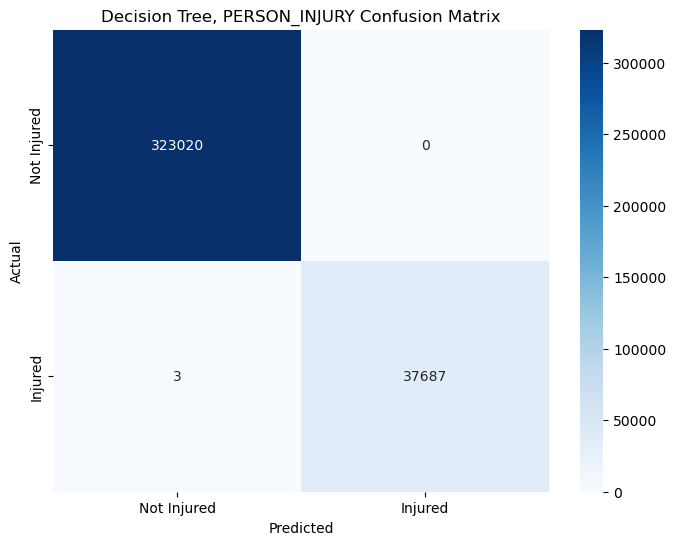

In [29]:
dtc(driversData, "PERSON_INJURY", "Not Injured", "Injured")

Decision Tree Classifer
Predicting PERSON_SEX
Mean Precision:  0.6194616317525986
Mean Recall:  0.619179185074741
Mean F1 Score:  0.6192582518163458


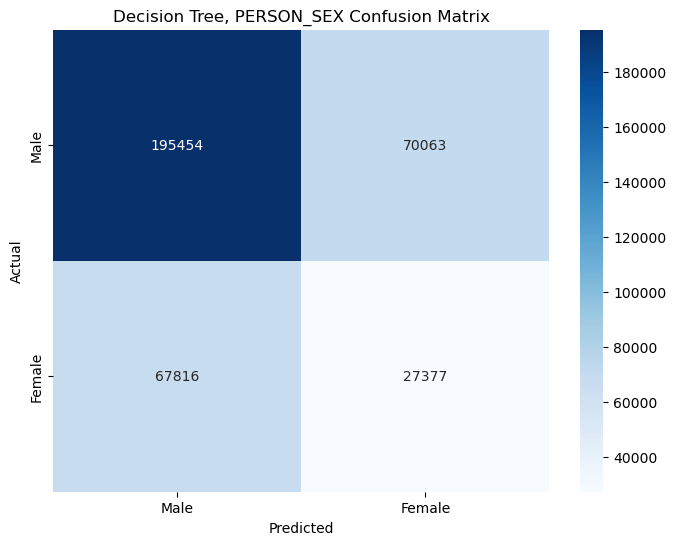

In [30]:
dtc(driversTranformed, "PERSON_SEX", "Male", "Female")

Decision Tree Classifer
Predicting AIR_BAG_DEPLOYED
Mean Precision:  0.9755952398331684
Mean Recall:  0.8766836976134613
Mean F1 Score:  0.9144704909160156


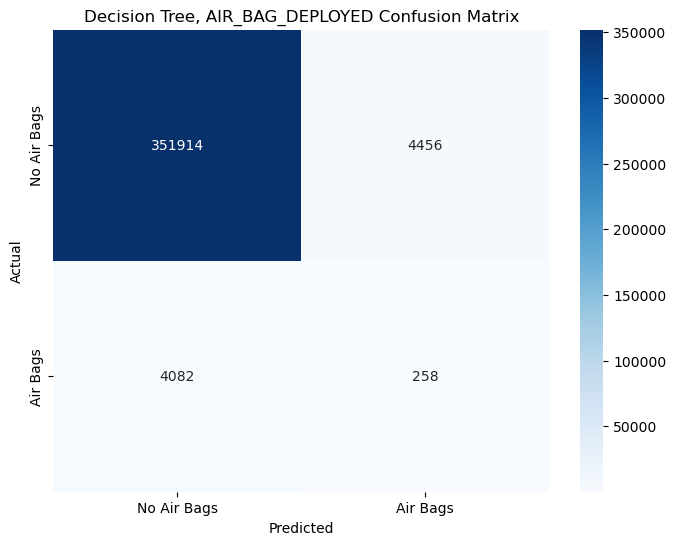

In [31]:
dtc(driversTranformed, "AIR_BAG_DEPLOYED", "No Air Bags", "Air Bags")

Decision Tree Classifer
Predicting HARNESS
Mean Precision:  0.7573664486571515
Mean Recall:  0.7031495846812653
Mean F1 Score:  0.7002181594659962


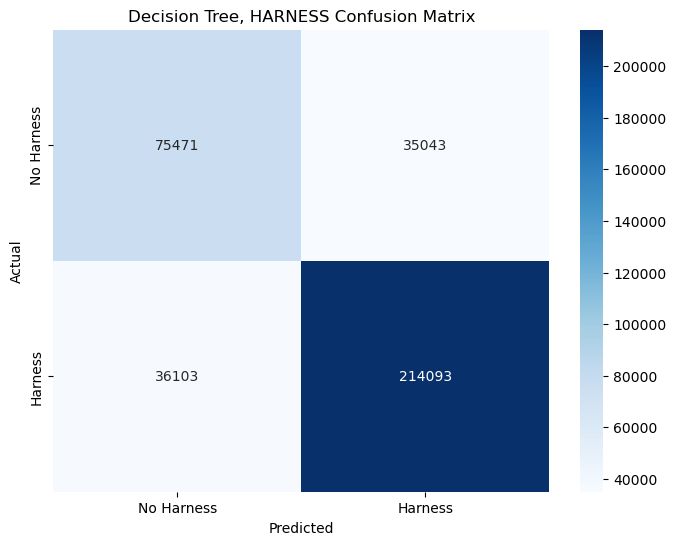

In [32]:
dtc(driversTranformed, "HARNESS", "No Harness", "Harness")

Decision Tree Classifer
Predicting LAP_BELT
Mean Precision:  0.8657325695495866
Mean Recall:  0.859881777768185
Mean F1 Score:  0.8618104154581172


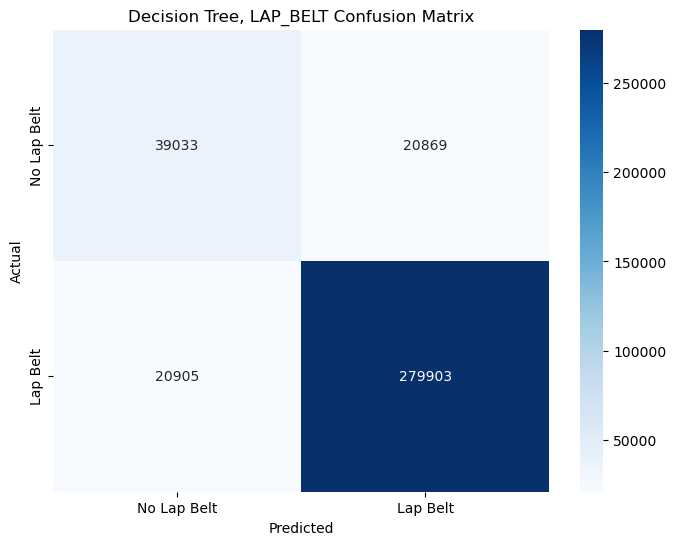

In [33]:
dtc(driversTranformed, "LAP_BELT", "No Lap Belt", "Lap Belt")

#### Update the PERSON_AGE to be bins of ranges and try to predict the ranges

In [60]:
# Define age bins and labels
bins = [1, 18, 35, 60, 123]
labels = ['teenager', 'young_adult', 'adult', 'elderly']

# Create a new categorical column
driversData['AGE_CATEGORY'] = pd.cut(driversData['PERSON_AGE'], bins=bins, labels=labels)
driversData = driversData.drop(['PERSON_AGE'], axis=1)

driversData

,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Severe Burn,COMPLAINT_Severe Lacerations,COMPLAINT_Unknown,COMPLAINT_Whiplash,PERSON_INJURY,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED,AGE_CATEGORY
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,0,young_adult
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,adult
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,young_adult
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,adult
27,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,adult
5513725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,adult
5513732,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,young_adult
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,elderly


In [62]:
print(driversData['AGE_CATEGORY'].unique())
driversData = driversData.dropna(subset=['AGE_CATEGORY'])
print(driversData['AGE_CATEGORY'].unique())

['young_adult', 'adult', 'elderly', 'teenager', NaN]
Categories (4, object): ['teenager' < 'young_adult' < 'adult' < 'elderly']
['young_adult', 'adult', 'elderly', 'teenager']
Categories (4, object): ['teenager' < 'young_adult' < 'adult' < 'elderly']


In [63]:
le = preprocessing.LabelEncoder()
driversData['AGE_CATEGORY'] = le.fit_transform(driversData['AGE_CATEGORY'])
driversData

/var/folders/9j/nc78x2y16qd1hdy75n60b0d80000gn/T/ipykernel_11165/3455020303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driversData['AGE_CATEGORY'] = le.fit_transform(driversData['AGE_CATEGORY'])


,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Severe Burn,COMPLAINT_Severe Lacerations,COMPLAINT_Unknown,COMPLAINT_Whiplash,PERSON_INJURY,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED,AGE_CATEGORY
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,0,3
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,3
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
27,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
5513725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
5513732,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,3
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,1


In [53]:
driversData

,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,EMOTIONAL_STATUS_Apparent Death,EMOTIONAL_STATUS_Conscious,EMOTIONAL_STATUS_Does Not Apply,EMOTIONAL_STATUS_Incoherent,EMOTIONAL_STATUS_Semiconscious,EMOTIONAL_STATUS_Shock,...,COMPLAINT_Severe Burn,COMPLAINT_Severe Lacerations,COMPLAINT_Unknown,COMPLAINT_Whiplash,PERSON_INJURY,PERSON_SEX,LAP_BELT,HARNESS,AIR_BAG_DEPLOYED,AGE_CATEGORY
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,0,3
8,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
10,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,3
19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
27,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513721,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,0
5513725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0
5513732,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,3
5513735,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1,0,1


Decision Tree Classifier
Predicting AGE_CATEGORY
Mean Precision:  0.4415848643213215
Mean Recall:  0.47865653302791566
Mean F1 Score:  0.3438267342972917


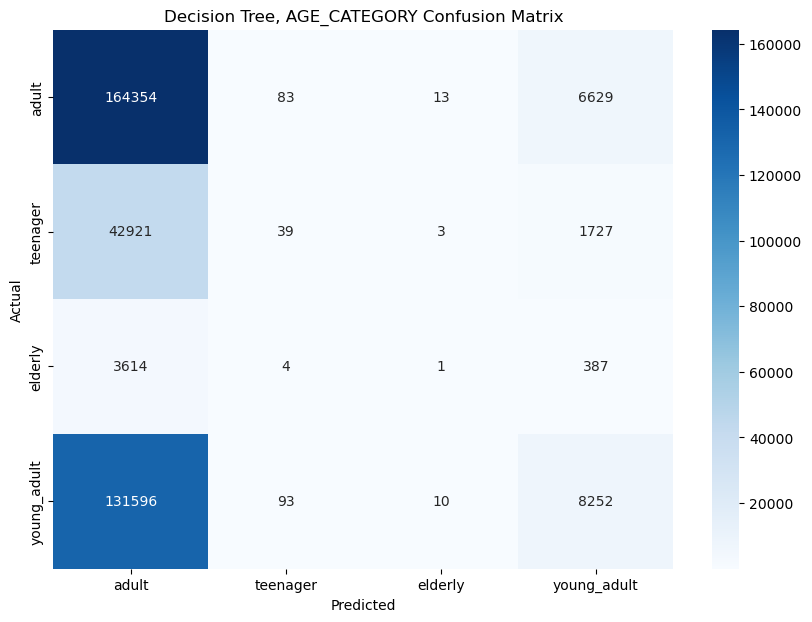

In [64]:
class_labels = ['adult', 'teenager', 'elderly', 'young_adult']

target = "AGE_CATEGORY"
# Split data into features (X) and target (y)
x = driversData.drop([target], axis=1)
y = driversData[target]

# Initialize the Decision Tree Classifier
clf = tree.DecisionTreeClassifier(criterion="entropy")

# Cross-validation scoring
scores = model_selection.cross_validate(clf, x, y, cv=5,
                                        scoring=["precision_weighted", "recall_weighted", "f1_weighted"])
print("Decision Tree Classifier")
print("Predicting " + target)
print("Mean Precision: ", np.mean(scores["test_precision_weighted"]))
print("Mean Recall: ", np.mean(scores["test_recall_weighted"]))
print("Mean F1 Score: ", np.mean(scores["test_f1_weighted"]))

# Train-test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=1/5.)

# Train the model
clf.fit(x_train, y_train)

# Predictions
y_pred = clf.predict(x_test)

# Generate confusion matrix for multi-class
cm = metrics.confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Decision Tree, {target} Confusion Matrix')
plt.show()